<a href="https://colab.research.google.com/github/joeyave/ai-project2/blob/main/ai_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/emergency_vs_non-emergency_dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
import os

home_path = r'/content/drive/MyDrive/Colab Notebooks/emergency_vs_non-emergency_dataset'

# Create train and validation directories
train_path = os.path.join(home_path, 'train')
# os.mkdir(train_path)
val_path = os.path.join(home_path, 'valid')
# os.mkdir(val_path)

# Create sub-directories
emergency_train_path = os.path.join(home_path + r'/train', 'emergency')
# os.mkdir(emergency_train_path)

non_emergency_train_path = os.path.join(home_path + r'/train', 'non_emergency')
# os.mkdir(non_emergency_train_path)

emergency_val_path = os.path.join(home_path + r'/valid', 'emergency')
# os.mkdir(emergency_val_path)

non_emergency_val_path = os.path.join(home_path + r'/valid', 'non_emergency')
# os.mkdir(non_emergency_val_path)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

df = pd.read_csv(home_path + r'/emergency_train.csv')

# Images and Labels
X = df.loc[:,'image_names']
y = df.loc[:,'emergency_or_not']

# Train-Test splitfor train and validation images
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, random_state = 27, stratify=y)

# Train df
df_train = pd.DataFrame(columns=['image_names','emergency_or_not'])
df_train['image_names'] = train_x
df_train['emergency_or_not'] = train_y

# Validation df
df_valid = pd.DataFrame(columns=['image_names','emergency_or_not'])
df_valid['image_names'] = val_x
df_valid['emergency_or_not'] = val_y

# Reset index
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [ ]:
# Save train images
for i in range(len(df_train)):

    image = df_train.loc[i,'image_names']

    if df_train.loc[i,'emergency_or_not'] == 0:
        shutil.copy(home_path + r'/images/' + image, non_emergency_train_path)
    else:
        shutil.copy(home_path + r'/images/' + image, emergency_train_path)
        
# Save validation images
for i in range(len(df_valid)):

    image = df_valid.loc[i,'image_names']

    if df_valid.loc[i,'emergency_or_not'] == 0:
        shutil.copy(home_path + r'/images/' + image, non_emergency_val_path)
    else:
        shutil.copy(home_path + r'/images/' + image, emergency_val_path)

Found 1481 images belonging to 2 classes.


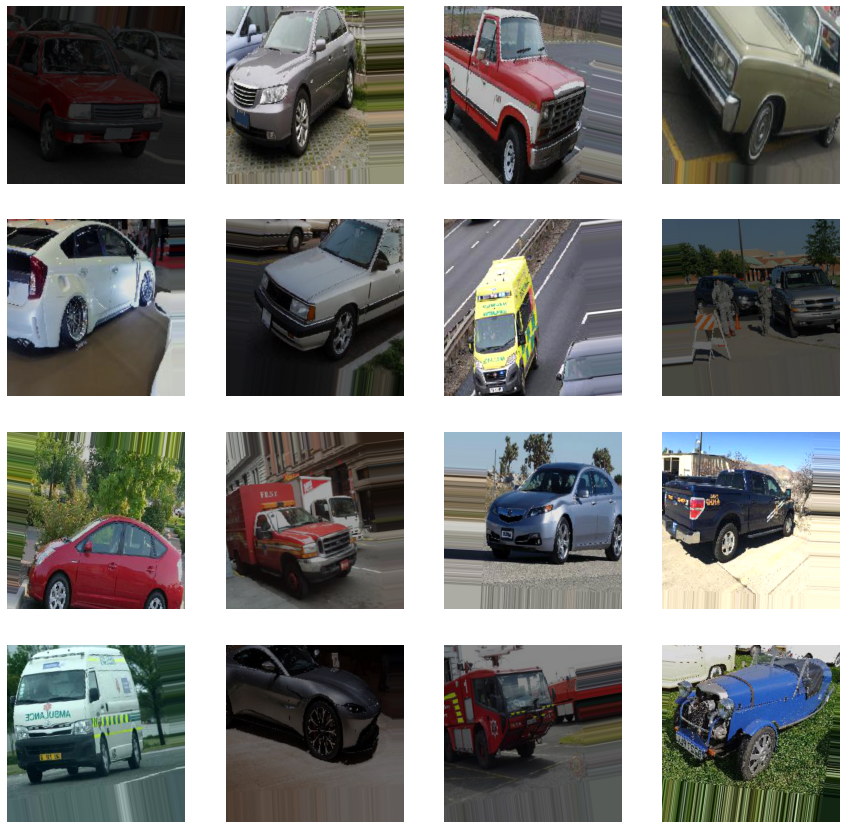

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

train_generator = datagen.flow_from_directory(
                  directory=home_path + r'/train/',
                  target_size=(400, 400), # resize to this size
                  color_mode="rgb", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="binary", # classes to predict
                  seed=2020 # to make the result reproducible
                  )

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
      # convert to unsigned integers for plotting
    image = next(train_generator)[0].astype('uint8')

    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    image = np.squeeze(image)

    ax.imshow(image)
    ax.axis('off')

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow import keras
from keras.utils import np_utils
import cv2

# Split data into train-test data sets

X = df.loc[:,'image_names']
y = df.loc[:,'emergency_or_not']

# Split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.1, 
                                                  random_state = 27, 
                                                  stratify=y)

# Train df
df_train = pd.DataFrame(columns=['image_name','category'])
df_train['image_name'] = train_x
df_train['category'] = train_y

# Test df
df_test = pd.DataFrame(columns=['image_name','category'])
df_test['image_name'] = val_x
df_test['category'] = val_y

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Images
train_images = df_train.loc[:,'image_name']
train_labels = df_train.loc[:,'category']

test_images = df_test.loc[:,'image_name']
test_labels = df_test.loc[:,'category']

# Train images
x_train = []
for i in train_images:
    image = home_path+'/images/'+i
    img = cv2.imread(image)
    x_train.append(img)

# Train labels
y_train = keras.utils.to_categorical(train_labels)

# Test images
x_test = []
for i in test_images:
    image = home_path+'/images/'+i
    img = cv2.imread(image)
    x_test.append(img)

# Test labels
y_test=keras.utils.to_categorical(test_labels)

# Normalize images
x_train = np.array(x_train, dtype="float") / 255.0
x_test = np.array(x_test, dtype="float") / 255.0

In [ ]:
# Model architechture
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.24))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
# Compile
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
# Fit
history = model.fit(x_train,y_train,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    batch_size=32,
                    verbose=1)

Epoch 1/10
47/47 [==============================] - 92s 2s/step - loss: 0.7028 - accuracy: 0.6455 - val_loss: 0.5544 - val_accuracy: 0.7091
Epoch 2/10
47/47 [==============================] - 90s 2s/step - loss: 0.4799 - accuracy: 0.7873 - val_loss: 0.4879 - val_accuracy: 0.7758
Epoch 3/10
47/47 [==============================] - 90s 2s/step - loss: 0.4268 - accuracy: 0.8116 - val_loss: 0.4479 - val_accuracy: 0.8000
Epoch 4/10
47/47 [==============================] - 90s 2s/step - loss: 0.3616 - accuracy: 0.8386 - val_loss: 0.4091 - val_accuracy: 0.7939
Epoch 5/10
47/47 [==============================] - 92s 2s/step - loss: 0.2710 - accuracy: 0.8866 - val_loss: 0.3962 - val_accuracy: 0.8061
Epoch 6/10
47/47 [==============================] - 90s 2s/step - loss: 0.1899 - accuracy: 0.9311 - val_loss: 0.6874 - val_accuracy: 0.7576
Epoch 7/10
47/47 [==============================] - 90s 2s/step - loss: 0.2427 - accuracy: 0.9014 - val_loss: 0.4846 - val_accuracy: 0.8000
Epoch 8/10
47/47 [==

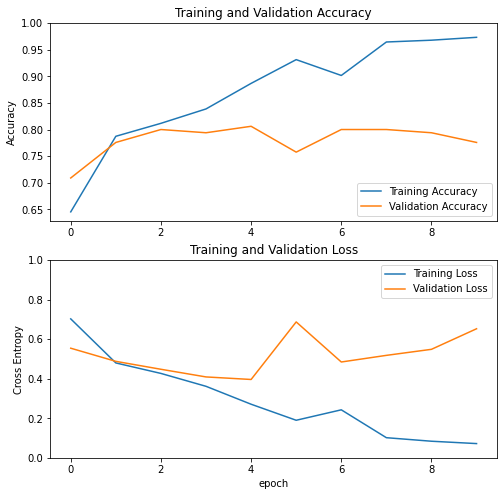

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()